# Plot temperature response over time

## Imports:

In [5]:
import xarray as xr
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

%load_ext autoreload
%autoreload 2

from ar6_ch6_rcmipfigs.utils.plot import get_var_nicename
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel
import numpy as np

from ar6_ch6_rcmipfigs.utils.badc_csv import write_badc_header

<IPython.core.display.Javascript object>

/Users/sarablichner/science/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs
/Users/sarablichner/science/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_in


### Paths input/output data

In [6]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, RESULTS_DIR, BASE_DIR

PATH_DT = OUTPUT_DATA_DIR / 'dT_data_RCMIP_recommendation.nc'

#### Paths uncertainties/percentiles

In [7]:
PATH_DT_UNCERTAINTY = OUTPUT_DATA_DIR / 'dT_uncertainty_data_FaIR_chris_ed02-3.nc'

In [8]:
base_year_uncertainty = 2020  # this is the base year used for the uncertainties.

#### output name: 
stem for output files

In [9]:
output_name = 'fig_timeseries_dT'

In [10]:
FIGURE_DIR = RESULTS_DIR / 'figures_recommendation/' / output_name

## Set values:

**Set reference year for temperature change:**

In [11]:
ref_year = 2019
last_y = 2100

In [12]:
from pathlib import Path

Path(FIGURE_DIR).mkdir(parents=True, exist_ok=True)

### Various definitions

Define variables to plot:

In [13]:
# variables to plot:
variables_erf_comp = [
    'aerosol-total-with_bc-snow',
    'ch4',
    'o3',
    'HFCs',
]

Scenarios:

In [14]:
scenarios_fl = ['ssp119',
                'ssp126',
                'ssp245',
                'ssp334',
                'ssp370',
                'ssp370-lowNTCF-aerchemmip',
                'ssp370-lowNTCF-gidden',
                'ssp585']

scenarios_fl_370 = ['ssp370', 'ssp370-lowNTCF-aerchemmip', 'ssp370-lowNTCF-gidden'  # Due to mistake here
                    ]

In [15]:
percentile = 'percentile'
climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

median = 'median'
perc5 = '5th percentile'
perc95 = '95th percentile'
recommendation = 'recommendation'

In [16]:
name_deltaT = 'Delta T'

## Open and prepare data: 

The code below plots data generated in step 02 in the notebooks:

In [17]:
ds_DT = xr.open_dataset(PATH_DT)
ds_uncertainty = xr.open_dataset(PATH_DT_UNCERTAINTY)

### Compute sum of variables
Compute the sum of al variables to create Sum SLCFs:

In [18]:
_str = ''
_vl = [get_var_nicename(var).split('(')[0].strip() for var in variables_erf_comp]
for var in _vl:
    _str += f'{var}, '

# ax.set_title('Temperature change, sum SLCF  (%s)' % _str[:-2])


vn_sum = 'Sum SLCF (%s)' % _str[:-2]
print(vn_sum)
# _st = vn_sum.replace('(','').replace(')','').replace(' ','_').replace(',','')+'.csv'

_da_sum = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable)
_da_sum  # .assin_coord()
ds_DT
# xr.concat([_ds_check[name_deltaT],_da_sum], dim=variable)

dd1 = _da_sum.expand_dims(
    {'variable': [vn_sum]})

ds_DT = xr.merge([ds_DT, dd1])

Sum SLCF (Aerosols, Methane, Ozone, HFCs)


### Reference change in GSAT up to 2019
The figures contain both difference with respect to pre industrial times (1750 here) and 2019. 
To harmonize with chapter 7, we use values from figure 7.7 where applicable (we lack HFCs) for the difference to 1750.

In [19]:
# values from fig 7.7
ds_DT
f_year = 1750
base_year = 2019
_ds_dt = ds_DT['Delta T'].copy(deep=True).to_dataset().sel(percentile='recommendation')
ds_dt_2019 = _ds_dt.sel(year=base_year) - _ds_dt.sel(year=f_year)  # se_da.sel(year=ref_year)).mean('scenario')

In [20]:
ds_dt_2019['Delta T'].loc[{'variable': 'o3'}] = 0.23
ds_dt_2019['Delta T'].loc[{'variable': 'ch4'}] = 0.28
ds_dt_2019['Delta T'].loc[{'variable': 'aerosol-total-with_bc-snow'}] = -0.5
# recompute sum for 2019: 
ds_dt_2019['Delta T'].loc[{'variable': vn_sum}] = \
    ds_dt_2019['Delta T'].loc[{'variable': 'o3'}] + \
    ds_dt_2019['Delta T'].loc[{'variable': 'ch4'}] + \
    ds_dt_2019['Delta T'].loc[{'variable': 'aerosol-total-with_bc-snow'}] + \
    ds_dt_2019['Delta T'].loc[{'variable': 'HFCs'}]

## Various plotting functions

### Generate figure axis: 

In [21]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_c_dic, \
    get_scenario_ls_dic


def get_fig_ax_tot(fgsize=None, nrows=2, ncols=3, rows_tot=0, cols_tot=2, tot_first=True, orientation='horizontal'):
    """
    Makes figure for total plot
    :param orientation: horizontal or vertical
    :param tot_first: plot with total comes first or second
    :param cols_tot:
    :param rows_tot:
    :param ncols:
    :param nrows:
    :param fgsize:
    :return:
    """
    if fgsize is None:
        fgsize = [11, 4.4]
    fg = plt.figure(constrained_layout=False, figsize=fgsize, dpi=150)
    if orientation == 'horizontal':
        _cols = ncols + cols_tot
        _rows = nrows
    else:
        _cols = ncols  # + cols_tot
        _rows = nrows + rows_tot

    spec2 = gridspec.GridSpec(ncols=_cols, nrows=_rows, figure=fg)
    com_axs = []
    if tot_first:
        if orientation == 'horizontal':
            all_ax = fg.add_subplot(spec2[:, 0:cols_tot])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[i, cols_tot + j]))
        else:

            all_ax = fg.add_subplot(spec2[0:rows_tot, :])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[rows_tot + i, j]))
    else:
        if orientation == 'horizontal':
            all_ax = fg.add_subplot(spec2[:, (-cols_tot):])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[i, j]))
        else:

            all_ax = fg.add_subplot(spec2[(-rows_tot):, :])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[i, j]))

    return fg, com_axs, all_ax

def fix_ax(_ax):
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)
    return


def fign_dt(_var, _s_y, _e_y):
    return '%s_refy%s_fy%s.png' % (_var.replace(' ', '_').replace('|', '-'), _s_y, _e_y)

### Functions to plot uncertainty

In [22]:
cdic = get_scenario_c_dic()
cdic: dict
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)


def add_uncertainty_bar(ax, var, end_y=last_y, s_y=ref_year,
                        to='p95-p50',
                        frm='p05-p50',
                        linewidth=4,
                        i_plus=1.5,
                        alpha=1,
                        ):
    _ds2100_err = ds_uncertainty.sel(year=end_y)
    _dT_2100 = ds_DT.sel(year=end_y) - ds_DT.sel(year=s_y)
    i = end_y + 1  # 2101
    # print(_ds2100.sel(scenario=scenarios_fl))
    for scn in scenarios_fl:
        _ds2100_err_scn = _ds2100_err.sel(scenario=scn, variable=var)
        _ds2100_scn = _dT_2100.sel(scenario=scn, variable=var)
        bot = float(-_ds2100_err_scn[frm])
        top = float(_ds2100_err_scn[to])

        mid = float(_ds2100_scn[name_deltaT])
        er = np.array([[bot, top], ]).transpose()
        eb1 = ax.errorbar(i, mid, yerr=er, c=cdic[scn],
                          linestyle=lsdic[scn], linewidth=linewidth,
                          alpha=alpha, zorder=100, clip_on=True, )
        # ax.scatter([i], [mid],c=cdic[scn],marker = '*',clip_on=False, zorder=100)
        i += i_plus
        eb1[-1][0].set_linestyle(lsdic[scn])
        eb1[-1][0].set_clip_on(False)

    # make shading
    _ds_err = ds_uncertainty
    make_shading_uncertainty(_ds_err, ax, frm, s_y, to, var)
    # write csv file:

    # _tbl = _ds_err[[to, frm]].sel(variable=var).squeeze().to_dataframe()
    # fn = FIGURE_DIR / get_fn(var, s_y, end_y, base_year_uncertainty, 'percentiles')
    # _tbl.to_csv(fn)
    # save uncertainty data
    save_da(_ds_err[to].sel(variable=var), var, to, s_y, end_y, delta_T=to)
    save_da(_ds_err[frm].sel(variable=var), var, to, s_y, end_y, delta_T=frm)


def make_shading_uncertainty(_ds_err, ax, frm, s_y, to, var):
    _ds = ds_DT - ds_DT.sel(year=float(s_y))
    for scn in scenarios_fl:
        _ds_err_scn = _ds_err.sel(scenario=scn, variable=var).squeeze()
        _ds_scn = _ds.sel(scenario=scn, variable=var).squeeze()
        bot = _ds_scn[name_deltaT] + _ds_err_scn[frm]
        top = _ds_scn[name_deltaT] + _ds_err_scn[to]
        ax.fill_between(bot['year'], bot, top, color=cdic[scn], alpha=0.05)

### Output filename csv

In [23]:
def get_fn(var_name, s_y, e_y, ref_y, perc):
    _st = var_name.replace('(', '').replace(')', '').replace(' ', '_').replace(',', '')  # +'.csv'
    fn = f'{output_name}_{perc}_{_st}_{s_y}-{e_y}_refyear{ref_y}.csv'
    return fn

### Save data to badc-csv

In [24]:
dic_head = dict(
    title='Data for Figure 6.22, warming for SSP scenarios',
    last_revised_date='2021-06-29',
    location='global',
    reference='https://github.com/sarambl/AR6_CH6_RCMIPFIGS/',
    source='IPCC AR6 output',
    creator='Sara Marie Blichner (s.m.blichner@geo.uio.no)',
    feature_type='Global mean time series',

)
add_global_comments = [
    ['comments', 'G', 'This data is based on the AR6 forcing time series.'],
    ['comments', 'G', 'Please see https://github.com/sarambl/AR6_CH6_RCMIPFIGS for methods'],
]


def get_add_global_from_dic(dic_head):
    add_global = [[key, 'G', dic_head[key]] for key in dic_head.keys()]
    add_global = add_global + add_global_comments
    return add_global

path_header_def = BASE_DIR / 'misc/header_empty.csv'
path_header_def.exists()



def save_da(da, var_name, perc, ref_year, e_y, delta_T='Delta T', ):
    if 'percentile' in da.coords:
        da = da.drop('percentile')

    df = da.to_dataframe()  # .drop('percentile', axis=1)
    df_out = df[delta_T].unstack().T

    fn = FIGURE_DIR / get_fn(var_name, ref_year, e_y, ref_year, perc)

    df_out.to_csv(fn)

    dic_head['title'] = get_title(perc, var_name, ref_year)

    add_global = get_add_global_from_dic(dic_head)

    write_badc_header(fn, fn, add_global, default_unit='degrees C',
                      fp_global_default=path_header_def,
                      fp_var_default=path_header_def)


def get_title(perc, var_name, ref_year):
    if perc == recommendation:
        txt = f'Data for Figure 6.22, warming for SSP scenarios for ' \
              f'forcing agent {get_var_nicename(var_name)} ({var_name}), ' \
              f'relative to year {ref_year} '
    else:
        txt = f'Data for Figure 6.22, percentile {perc} warming for ' \
              f'SSP scenarios for forcing agent {get_var_nicename(var_name)} ({var_name}), ' \
              f'relative to year {ref_year}'

    return txt

### Figure fixes: 

In [25]:
# xticks: 
ls_xticks = [2020, 2040, 2060, 2080, 2100]

# defining yticks for each subplot: 
ytick_dic = {
    'aerosol-total-with_bc-snow': [-.2, .0, .2, .4, .6],
    'ch4': [0., -0.2, 0, .2],  # ,.4],
    'o3': [-.2, 0., .2, ],  # ,.6],
    'HFCs': [0, .1, .2, ],
    'Sum SLCF (Aerosols, Methane, Ozone, HFCs)': [0, .2, .4, .6, .8, 1, 1.2]
}
ytick_dic_pi = {
    'aerosol-total-with_bc-snow': [-.6, -.3, 0.],
    'ch4': [0.2, .4, .6],
    'o3': [0., .2, .4, .6],
    'HFCs': [0., .1, .2, .3],
    'Sum SLCF (Aerosols, Methane, Ozone, HFCs)': [0, .2, .4, .6, .8, 1, 1.2]
}


# set ylims for the plots

def set_ylim_sec_ax(ds_2019, var, ax1,
                    # ref_year=1750,
                    # ref_y_first_ax=2019,
                    adj=10,
                    l_tick=2,
                    xlim=None,
                    c=None
                    ):
    if c is None:
        c = (0, 128 / 256, 128 / 256,)

    if xlim is None:
        xlim = [1998, 2100]
    # as long as both ref_year and ref_y_first_ax are in historical period, all scenarios are the same:
    se_da = ds_2019.sel(variable=var).isel(scenario=0).squeeze()[name_deltaT]

    # difference_y1_y2 = (se_da.sel(year=ref_y_first_ax) - se_da.sel(year=ref_year)).mean('scenario')
    difference_y1_y2 = float(se_da)
    _yticks = ytick_dic_pi[var]
    for yt in _yticks:
        ax1.text(xlim[0] + adj, yt - difference_y1_y2, '%.1f' % yt, ha='center', va='center',
                 color=c)  # color=(0,128/256,128/256,))
        ax1.hlines(yt - difference_y1_y2, xlim[0], xlim[0] + l_tick, color=c)
    # ax2.set_ylim([ylims[0]+difference_y1_y2, ylims[1]+difference_y1_y2])
    bound_yax(ax1, red_ybound=.1)
    # bound_yax(ax2, red_ybound=.1)

    return difference_y1_y2


def add_reftext(ax, y_pos=.9, c=None):
    if c is None:
        c = (0, 128 / 256, 128 / 256,)

    ax.text(-0., y_pos,
            'Ref 2019 ',
            ha='right',
            va='bottom',
            transform=ax.transAxes)
    ax.text(-0., y_pos,
            ' Ref 1750',
            ha='left',
            va='bottom',
            transform=ax.transAxes,
            color=c
            )


def bound_yax(ax, red_ybound=.1):
    bounds = ax.get_ybound()  # [0]
    to = bounds[1]
    bo = bounds[0]
    ax.spines['left'].set_bounds(low=bo, high=(to - (to - bo) * red_ybound))

In [26]:
def get_difference_var(ds_DT, ref_year, var, last_y):
    da_var = ds_DT[name_deltaT].sel(variable=var, year=slice(ref_year, last_y))
    da_var_ref_year = da_var.sel(year=ref_year).squeeze()
    # take difference to ref year
    da_var_diff = da_var - da_var_ref_year
    return da_var_diff

## Main plot:

In [27]:
def make_main_plot(ds_rec, ref_year=ref_year, end_year=last_y, linewidth=2):
    figsize = [7, 9]  # [6, 4]

    fig2, axs, ax_tot = get_fig_ax_tot(fgsize=figsize,
                                       rows_tot=2,
                                       cols_tot=0,
                                       ncols=2,
                                       orientation='vertical',
                                       tot_first=False)

    # fig3 = plt.figure(constrained_layout=True)
    # _ds = ds_DT.sel(year=slice(s_y2, e_y2))
    for var, ax in zip(variables_erf_comp, axs):
        print(var)
        # select var and years
        da_var_diff = get_difference_var(ds_rec, ref_year, var, end_year)
        # plot mean:
        for scn in scenarios_fl:  # list(set(scenarios_fl) - {'historical'}):
            _pl_da = da_var_diff.sel(scenario=scn)
            # Plot mean:
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=linewidth)

        # save csv:
        save_da(da_var_diff, var, recommendation, ref_year, end_year, delta_T='Delta T', )
        # save_csv_mean(da_var_diff, ref_year, var)
        # various labels:
        ax.set_title('%s' % get_var_nicename(var))

        ax.set_xlabel('')
        ax.set_ylabel('')
        # Plot zero line:
        if 'aerosol' in var:
            ax.hlines(0, 2014, 2100, linewidth=.8, alpha=0.5)
        else:
            ax.hlines(0, 1990, 2100, linewidth=.8, alpha=0.5)

        add_uncertainty_bar(ax, var, linewidth=2.3, i_plus=1.7, s_y=ref_year, end_y=end_year)
        fix_ax(ax)
        ax.spines['bottom'].set_bounds(2019, 2100)
        bound_yax(ax)
        ax.set_xlim([1998, 2100])
        set_ylim_sec_ax(ds_dt_2019, var, ax, )
        ax.set_yticks(ytick_dic[var])
        ax.set_xticks(ls_xticks)

    add_reftext(axs[0])

    for ax in axs[0::2]:
        ax.set_ylabel('($^\circ$C)')

    if len(axs) > len(variables_erf_comp):
        l = len(variables_erf_comp)
        for i in range(l, len(axs)):
            axs[l].axis('off')

    # Total:

    ax = ax_tot
    var = 'Sum SLCF (Aerosols, Methane, Ozone, HFCs)'

    # for var in variables_erf_tot:  # , f_totn]:
    # select var and years
    da_var = ds_rec[name_deltaT].sel(variable=variables_erf_comp).sum(variable)
    da_var = da_var.sel(year=slice(ref_year, end_year))
    da_var_ref_year = da_var.sel(year=ref_year).squeeze()
    # take difference to ref year
    da_var_diff = da_var - da_var_ref_year

    for scn in scenarios_fl:
        _pl_da = da_var_diff.sel(scenario=scn)
        # Plot mean:
        _pl_da.plot(ax=ax, c=cdic[scn],
                    label=trans_scen2plotlabel(scn),
                    linestyle=lsdic[scn],
                    linewidth=linewidth
                    )

    # save csv:
    # save_csv_mean(da_var_diff, ref_year, var)
    save_da(da_var_diff, var, recommendation, ref_year, end_year, delta_T='Delta T', )

    add_uncertainty_bar(ax, var, linewidth=3,
                        i_plus=.8)
    # _ds = ds_DT.sel(year=slice(s_y2, e_y2))
    plt.suptitle('Effect on Global Surface Air Temperature (GSAT) relative to 2019', fontsize=14, y=1.0)
    # adjust plot visuals:
    _str = ''
    _vl = [get_var_nicename(var).split('(')[0].strip() for var in variables_erf_comp]
    for var in _vl:
        _str += f'{var}, '
    ax.set_title('Sum SLCF (%s)' % _str[:-2])
    ax.set_title('Sum SLCFs (Aerosols, Methane, Ozone) + HFCs')
    ax.hlines(0, 1990, 2100, linewidth=.8, alpha=0.5)

    # ax.set_ylabel('$\Delta$ T ($^\circ$C)')
    ax.set_ylabel('($^\circ$C)')
    ax.set_xlabel('')

    fix_ax(ax)
    ax.spines['bottom'].set_bounds(2019, 2100)
    ax.set_xlim([2010, 2100])
    add_reftext(ax)
    ax.text(1.1, .85,
            '5th-95th\npercentile\n2100',
            ha='right',
            va='bottom',
            alpha=.7,
            transform=ax.transAxes)
    var = 'Sum SLCF (Aerosols, Methane, Ozone, HFCs)'
    ax.set_ylim([-.1, 1.5])
    set_ylim_sec_ax(ds_dt_2019, var, ax, adj=5, l_tick=1, xlim=[2010, 2100])
    ax.set_yticks(ytick_dic[var])
    ax.set_xticks(ls_xticks)

    ax.legend(frameon=False, loc='upper center', ncol=2)
    plt.subplots_adjust(top=0.94, left=0.125, wspace=.5, hspace=.6)
    # plt.tight_layout()# w_pad=4)#rect=[0,0,.94,1],
    fp = FIGURE_DIR / output_name
    plt.savefig(fp.with_suffix('.png'), dpi=300, bbox_inches='tight')
    plt.savefig(fp.with_suffix('.pdf'), bbox_inches='tight')  # , dpi=300)
    plt.show()

aerosol-total-with_bc-snow
ch4
o3
HFCs


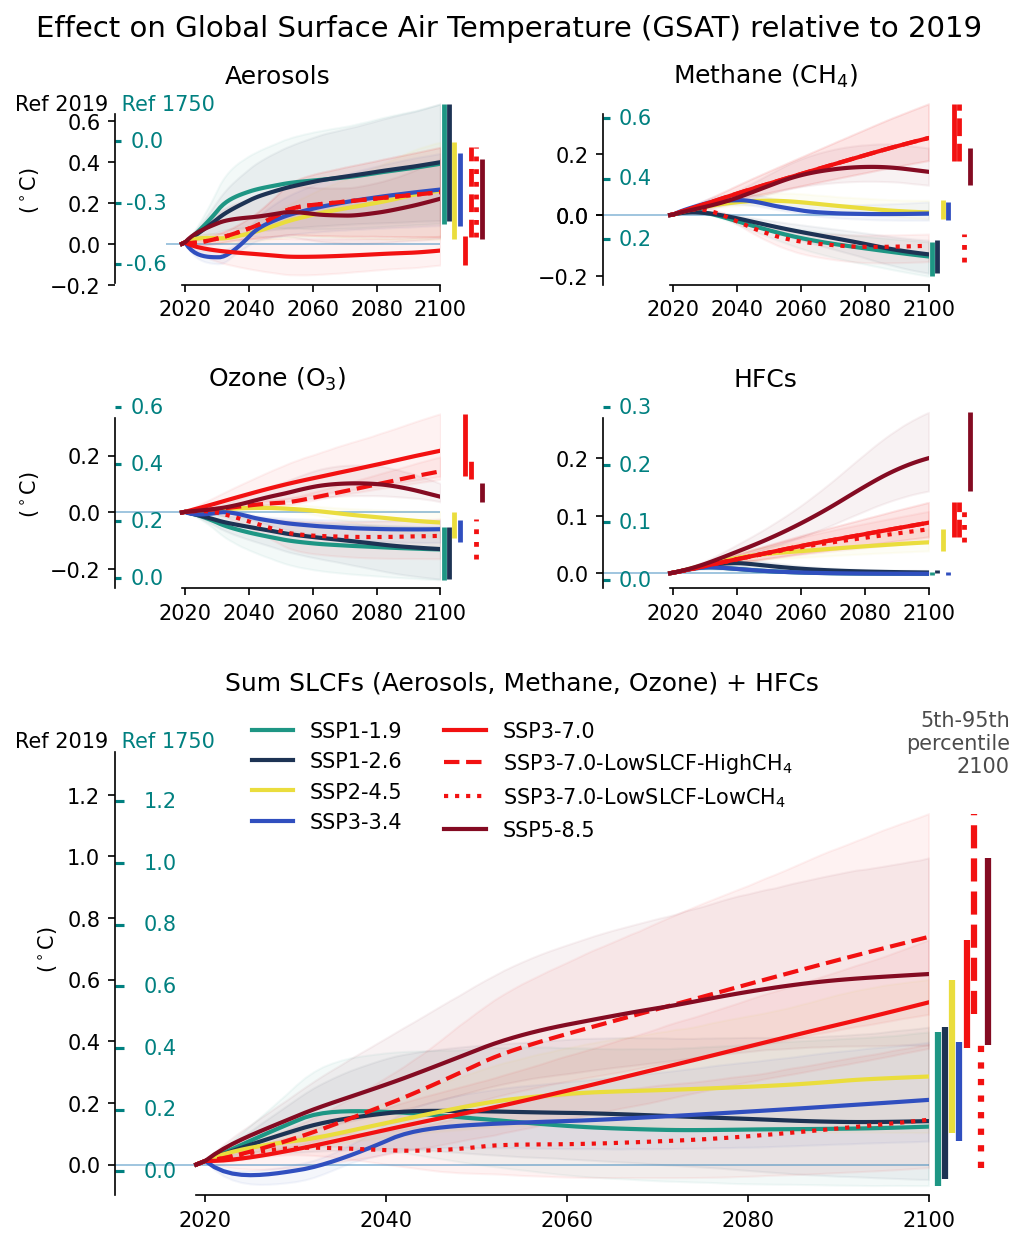

In [28]:
make_main_plot(ds_DT.sel(percentile=recommendation),
               ref_year=ref_year, end_year=last_y)

# Supplementary plots:

In [29]:
scenarios_fl = ['ssp119',
                'ssp126',
                'ssp245',

                # 'ssp370',
                'ssp370-lowNTCF-aerchemmip',
                'ssp370-lowNTCF-gidden',
                'ssp585']

In [30]:
ref_year

2019

aerosol-total-with_bc-snow


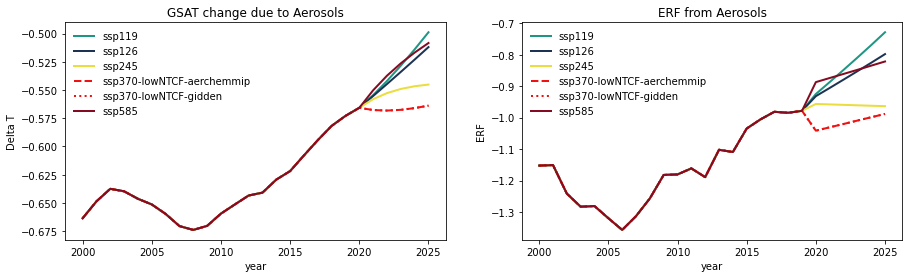

ch4


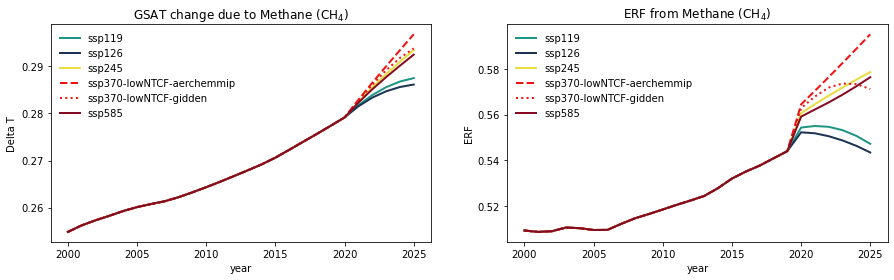

o3


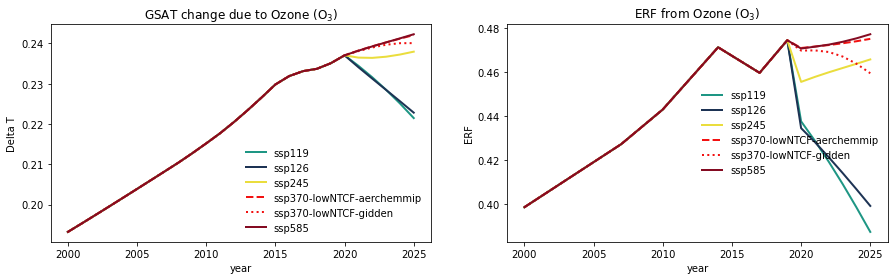

HFCs


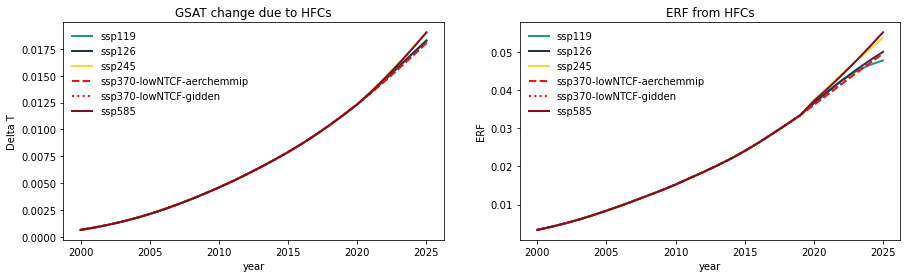

In [31]:

for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[15, 4])
    for scn in scenarios_fl:  # ) - {'historical'}):
        first = True

        _da1 = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(2000, 2025)).sel(percentile=recommendation)
        _da2 = ds_DT['ERF'].sel(variable=var, scenario=scn, year=slice(2000, 2025))
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da  # .sel(percentile='median')#.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=2)
    print(var)

    axs[0].set_title('GSAT change due to %s' % get_var_nicename(var))
    axs[1].set_title('ERF from %s' % get_var_nicename(var))

    axs[0].legend(frameon=False)  # , loc=2)
    axs[1].legend(frameon=False)  # , loc=2)

    plt.show()

with respect to year 2020

aerosol-total-with_bc-snow


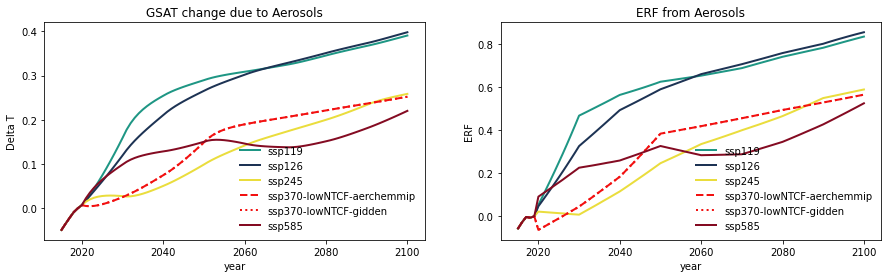

ch4


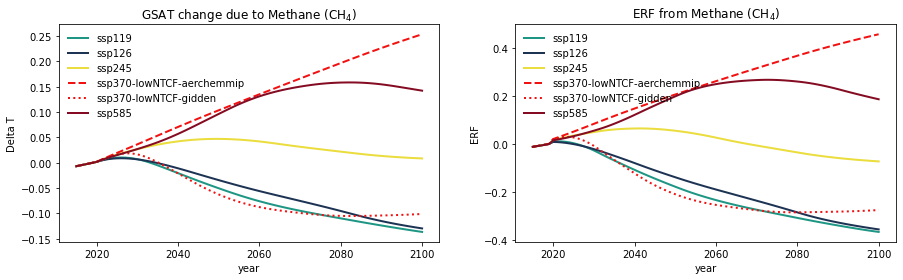

o3


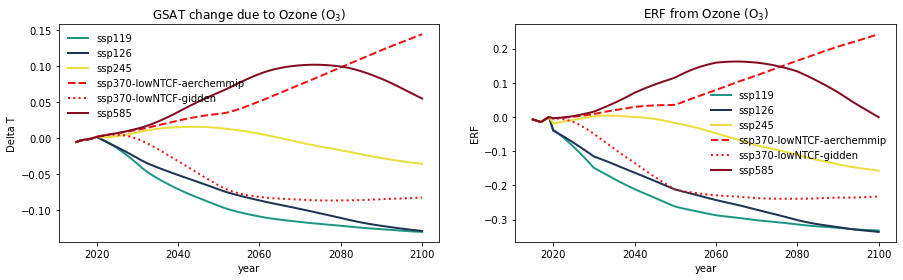

HFCs


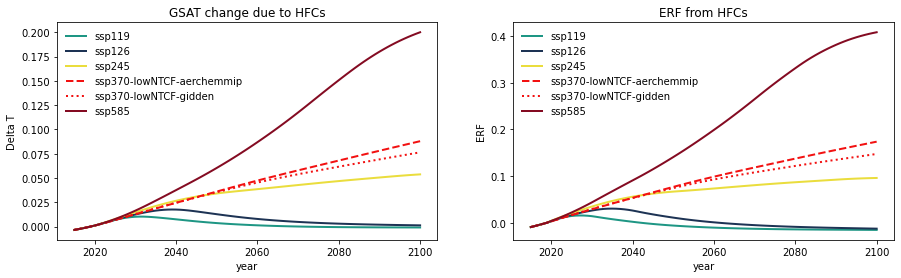

In [33]:

# Get linestyle scenarios:
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)

s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# Get colorscheme scenarios
cdic = get_scenario_c_dic()
alpha = 0.3
for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[15, 4])
    for scn in scenarios_fl:  # ) - {'historical'}):
        first = True
        _da1 = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2)) - ds_DT[name_deltaT].sel(
            variable=var, scenario=scn,
            year=slice(s_y, s_y)).squeeze()
        _da1 = _da1.sel(percentile=recommendation)
        _da2 = ds_DT['ERF'].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2)) - \
               ds_DT['ERF'].sel(variable=var, scenario=scn, year=slice(s_y, s_y)).squeeze()
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da  # .sel(percentile='median')#.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=2)
    print(var)

    axs[0].set_title('GSAT change due to %s' % get_var_nicename(var))
    axs[1].set_title('ERF from %s' % get_var_nicename(var))

    axs[0].legend(frameon=False)  # , loc=2)
    axs[1].legend(frameon=False)  # , loc=2)

    plt.show()